In [1]:
import numpy as np
from sklearn import metrics
import tensorflow as tf
from keras.layers import LSTM, Dense, InputLayer, Dropout, GRU
from keras import Sequential
import config
import tsetmcapi
from datetime import datetime
import math
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_date(today : datetime):
    month, day = str(today.month), str(today.day)
    if len(month) == 1:
        month = '0'+month
    if len(day) == 1:
        day = '0'+day

    return str(today.year)+month+day

In [3]:
def scale(arr, low=0, up=1):
    min_arr = min(arr)
    max_arr = max(arr)
    scaled = [(up - low) * (item - min_arr) / (max_arr - min_arr) + low for item in arr]
    return scaled
	

In [4]:
def prepare_date(close_price, volume, percent_change):
    x = []
    y = []
    for i in range(len(close_price)):
        x.append(np.array([close_price[i], volume[i]]))
        y.append(percent_change[i])

    x = np.asarray(x)
    y = np.asarray(y).astype('float32')

    test_size = (len(x)//10)*2

    x_train = x[:-1*test_size]
    y_train = y[:-1*test_size]
    x_test = x[-1*test_size:]
    y_test = y[-1*test_size:]
    return x_train, y_train, x_test, y_test

In [5]:
today = datetime.now()
# ins_code = 65883838195688438 #خودرو
# ins_code = 28320293733348826 #وبصادر
# ins_code = 51617145873056483 #شتران
# ins_code = 35425587644337450 #فملی

today_text = get_date(today)
ins_code = 35425587644337450
trade_data = tsetmcapi.inst_trade(
    config.username,
    config.password,
    ins_code,
    date_from=20190101,
    date_to=today_text)

In [6]:
all_close_price = [float(d[3][1]) for d in trade_data]
all_volume = [float(d[9][1]) for d in trade_data]

In [7]:
percent_change, close_price, volume = [], [], []

for i in range(len(all_close_price)-1):
    percent = (all_close_price[i+1] - all_close_price[i]) / all_close_price[i]
    if percent <= 0.05 and percent >= -0.05:
        percent_change.append(percent)
        close_price.append(all_close_price[i])
        volume.append(all_volume[i])
    else:
        print(i, percent)

253 -0.19353577479473477
286 -0.07639929184257116
315 0.09611250447868147
462 -0.49314574314574317
464 0.14590747330960854
509 0.05979760809567617
510 0.05555555555555555
514 0.05358615004122012
532 0.05154639175257732
556 0.05336832895888014
561 0.053428317008014245
695 -0.4996237772761475


In [8]:
#close_price, volume = scale(close_price), scale(volume)

In [9]:
percent_change, close_price, volume = scale(percent_change), scale(close_price), scale(volume)

In [10]:
x_train, y_train, x_test, y_test = prepare_date(close_price, volume, percent_change)

In [11]:
x_train.shape

(631, 2)

In [12]:
x_train.shape = x_train.shape + (1,)

In [13]:
x_test.shape = x_test.shape + (1,)

In [14]:
print(x_train.shape, x_test.shape)

(631, 2, 1) (156, 2, 1)


In [15]:
print(y_train.shape, y_test.shape)

(631,) (156,)


In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'sgd', loss = 'mean_squared_error', metrics=['acc'])

histo = regressor.fit(x_train, y_train, epochs = 100, batch_size = 32)

In [109]:
from keras.layers import Bidirectional

In [110]:
model = Sequential()
model.add(Bidirectional(LSTM(units=50, activation='relu', return_sequences=True)))
model.add(LSTM(units=20, activation='relu', return_sequences=False))
model.add(Dense(10))
model.add(Dense(5))
model.add(Dense(1))
model.compile(optimizer='adam', loss= tf.keras.losses.MeanSquaredError(), metrics=['acc'])

In [140]:
history = model.fit(x_train, y_train, batch_size=16, epochs=100)

Epoch 1/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0718 - acc: 0.0016
Epoch 2/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0718 - acc: 0.0016
Epoch 3/100
40/40 [==============================] - 1s 19ms/step - loss: 0.0714 - acc: 0.0016
Epoch 4/100
40/40 [==============================] - 1s 19ms/step - loss: 0.0714 - acc: 0.0016
Epoch 5/100
40/40 [==============================] - 1s 20ms/step - loss: 0.0714 - acc: 0.0016
Epoch 6/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0720 - acc: 0.0016
Epoch 7/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0713 - acc: 0.0016
Epoch 8/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0715 - acc: 0.0016
Epoch 9/100
40/40 [==============================] - 1s 19ms/step - loss: 0.0720 - acc: 0.0016
Epoch 10/100
40/40 [==============================] - 1s 19ms/step - loss: 0.0713 - acc: 0.0016
Epoch 11/100
40/40 [=============================

In [141]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 2, 100)            20800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 20)                9680      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 6         
Total params: 30,751
Trainable params: 30,751
Non-trainable params: 0
_________________________________________________________________


In [142]:
history.history.keys()

dict_keys(['loss', 'acc'])

In [143]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)

In [144]:
from matplotlib import pyplot

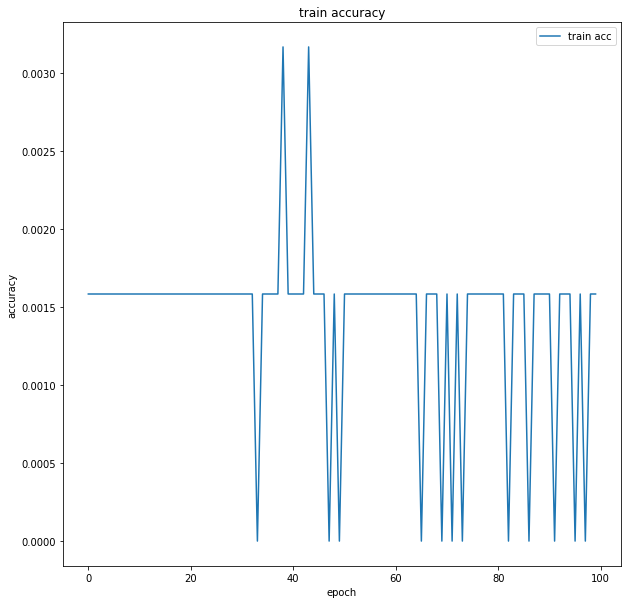

In [145]:
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc'])
pyplot.savefig('train_acc')
plt.show()

In [146]:
# plt.plot(history.history['val_acc'])
# # plt.plot(history.history['val_acc'])
# plt.title('validation accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['validation acc'])
# pyplot.savefig('validation_acc')
# plt.show()

In [147]:
# # plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['validation loss', 'validation'])
# pyplot.savefig('validation_loss')
# plt.show()

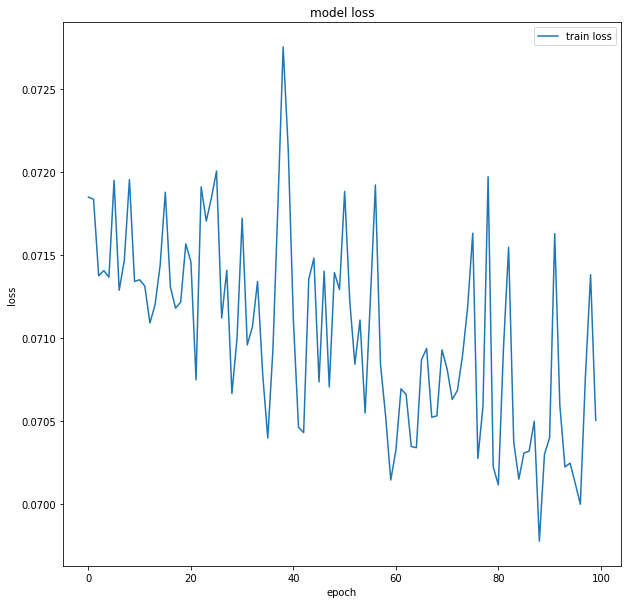

In [148]:
# plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation'])
pyplot.savefig('train_loss')
plt.show()

In [149]:
pred = model.predict(x_test)

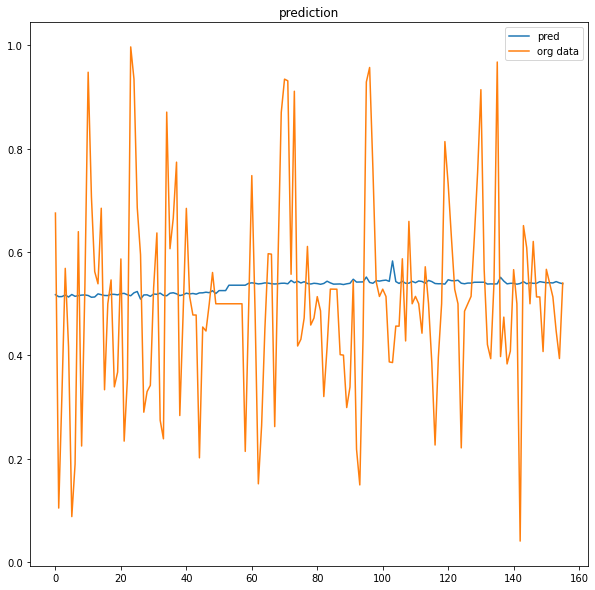

In [150]:
plt.plot(pred)
plt.plot(y_test)
plt.title('prediction')
# plt.ylabel('loss')
# plt.xlabel('epoch')
plt.legend(['pred', 'org data'])
pyplot.savefig('pred_org')
plt.show()

In [151]:
pred[:10]

array([[0.5174057 ],
       [0.51352763],
       [0.51376927],
       [0.51688147],
       [0.51287735],
       [0.5177633 ],
       [0.51425344],
       [0.51553655],
       [0.51659334],
       [0.5169179 ]], dtype=float32)

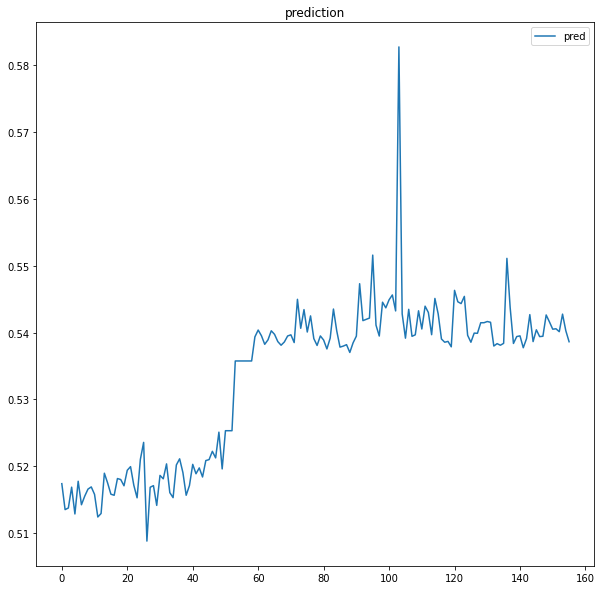

In [152]:
plt.plot(pred)
plt.title('prediction')

plt.legend(['pred'])
pyplot.savefig('pred')
plt.show()

In [153]:
true = 0
for i in range(len(pred)):
    if pred[i] == y_test[i]: true += 1

In [154]:
print("acc = ", true/len(pred))

acc =  0.0


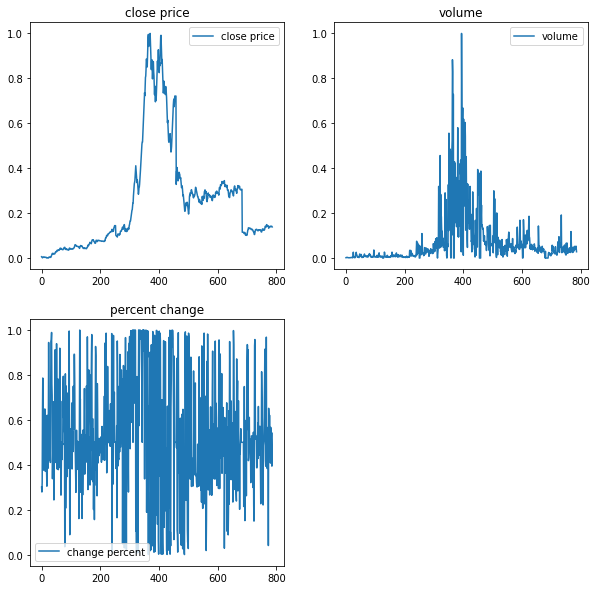

In [155]:
plt.subplot(2,2,1)
plt.plot(close_price)
plt.title('close price')

plt.legend(['close price'])

plt.subplot(2,2,2)
plt.plot(volume)
plt.title('volume')

plt.legend(['volume'])

plt.subplot(2,2,3)
plt.plot(percent_change)
plt.title('percent change')

plt.legend(['change percent'])

pyplot.savefig('all data')
plt.show()

In [156]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)

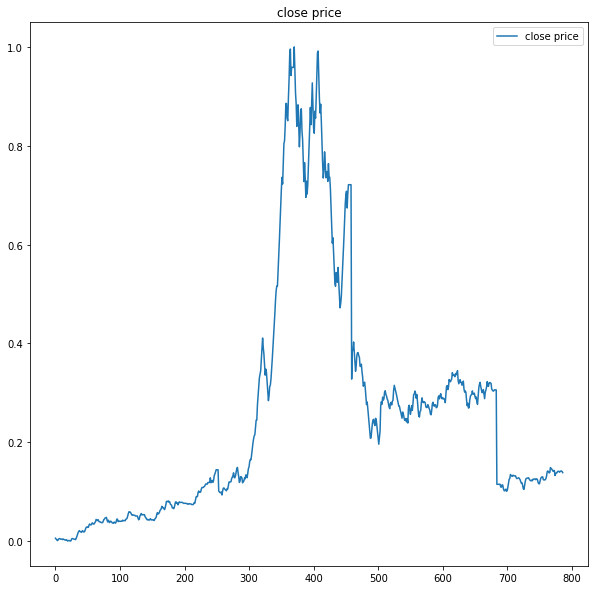

In [157]:
plt.plot(close_price)
plt.title('close price')

plt.legend(['close price'])
plt.show()

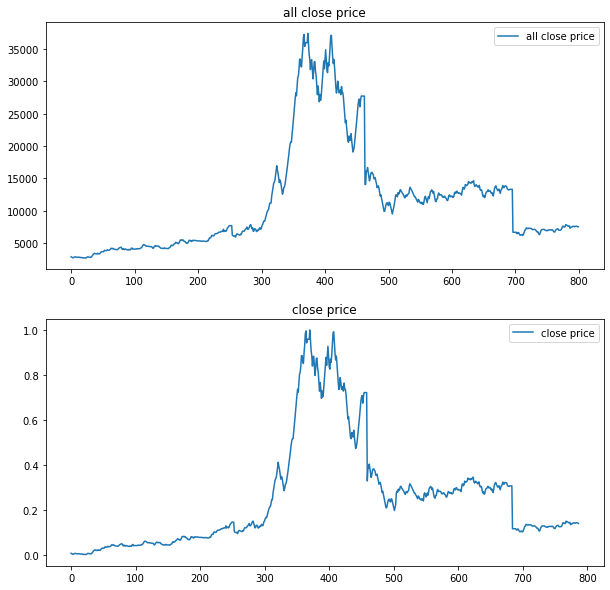

In [158]:
plt.subplot(2,1,1)
plt.plot(all_close_price)
plt.title('all close price')

plt.legend(['all close price'])

plt.subplot(2,1,2)
plt.plot(close_price)
plt.title('close price')

plt.legend(['close price'])

plt.show()

In [159]:
print(all_close_price[400:420])

[33510.0, 34880.0, 33360.0, 31700.0, 31340.0, 32890.0, 32400.0, 33750.0, 35390.0, 36990.0, 37120.0, 35560.0, 33790.0, 32760.0, 33380.0, 32180.0, 30730.0, 29200.0, 28190.0, 28730.0]


In [160]:
print(len(all_close_price), len(close_price))

800 787


In [161]:
min(close_price)

0.0

In [162]:
close_price[289]

0.12755733317986936

In [163]:
for prc in percent_change:
    if prc > 0.05 or prc < -0.05:
        print(prc)

0.3003865895227175
0.27848348786480953
0.3209318783572128
0.6298859869417968
0.7859868250969283
0.6068101249252903
0.471564099878437
0.3759232784585214
0.5320514998270499
0.45693278924290487
0.40293561244617876
0.6483245727674204
0.4141282019899128
0.37018322973893236
0.4852078332571878
0.4230854291779168
0.6175978998131381
0.368816377294419
0.3044058172164333
0.6201212230252464
0.5146601630009584
0.46640950726727465
0.3844067856871056
0.5826449211980443
0.9442421137874679
0.6428376108781744
0.46806837080092734
0.4290627226163637
0.42143513933621835
0.489028275992537
0.40994956727903004
0.7500287725179615
0.9491298678135132
0.9569063761306379
0.9887444870104374
0.7591224993452681
0.7074331914000995
0.3376574058533705
0.4368703561456112
0.3671145126457691
0.6739946994144056
0.6800251907839934
0.2430938368988482
0.5876199434862766
0.42474917432381976
0.8567086840712674
0.9115869679659488
0.6793211936174959
0.5659329402550127
0.40946086748920096
0.5053234414392742
0.9387851956642378
0.706